# Notebook - Fundamentals of MPC.

This notebook can be seen as an interactive version of Lecture 2. 

**About using the notebook**

To run the notebook, you must execute the cells under "Imports and necessary classes" first. 

After this, each section in the notebook is a standalone section, so you do not have to execute the cells in Section 2 in order to work with Section 3, etc.

In several places, there is a **Task** that asks you to modify some parameters and try to connect the results with the discussion we had during the lecture.

# Table of content
* ### [1. Imports and necessary classes](#sec1)
 * #### [1.1 The LTI-class](#sec1_1)
 * #### [1.2 The FiniteHorizon-class](#sec1_2)
* ### [2. Finite horizon control](#sec2)
* ### [3. Linear quadratic control without constraints](#sec3)
 * #### [3.1 Unconstrained linear quadratic MPC](#sec3_1)
* ### [4. Linear quadratic control with input constraints](#sec4)
* ### [5. State constraints, terminal region and feasability.](#sec5)
 * #### [5.1 Adding state and input constraints](#sec5_1)
 * #### [5.2 Adding terminal constraint](#sec5_2)


# 1. Imports and necessary classes <a id="sec1">

In [1]:
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

**Uncomment and execute the cell below if you want your plots to open in an external window!** This can be very useful in order to compare figures with different parameters. (It may be that on Windows and Mac you have to change `qt` to a different package).

In [2]:
#%matplotlib qt

## 1.1 The LTI-class <a id="sec1_1">

The `LTI`-class below defines an LTI-system
$$ \begin{aligned} x(t+1) &= A x(t) + B(t) \\ y(t)&= C x(t) \end{aligned}$$
(Same thing as $$ \begin{aligned} x(t+1) &= A x(t) + B u(t) \\ y(t)&= C x(t) \end{aligned}$$
?)

When you create the class you specify $A$, $B$ and $x(0)$,

`sys = LTI(A,B,x0)`

You can then step forward by applying the input

`xnext = sys.step(u)`

*Note:* Here `u` must be a `numpy`-array of the right dimension. This notebook will consider single input systems, so the input is a $1 \times 1$-matrix. That is, if we want to supply $u(t) = 2$ we use e.g. `u = np.array([[2]])` or `u = 2*np.ones((1,1))`. 

**Getting the state, output and input trajectories**: The class saves the state and input trajectory in `sys.X` and `sys.U,` where each column corresponds to one time step. If you want the output trajectory, you can use `C@sys.X`, since $CX = \begin{bmatrix} Cx(0) & C x(1) & \ldots & C x(N) \end{bmatrix}$.

**Constraints on the input:** If you set `umax < np.inf`, then any input such that $|u(t)| >$`umax` will be truncated.

**Task**: Read the code and make sure you understand what it does.


In [2]:
class LTI:
    def __init__(self, A, B, x0, umax=np.inf):
        self.A = A  #A
        self.B = B #B
        self.n, self.m = B.shape  #n,m. Dimension of B
        self.umax = umax #U_max
        x0 = x0.reshape(self.n,1)
        self.X = x0
        self.U = np.empty((self.m,0)) 

    def step(self, u):
        # Imposte consraints on the input
        u = u.reshape(self.m,1)
        u[u>self.umax] = self.umax #Umax = inf --> infinite Horizon
        u[u<-self.umax] = -self.umax #????

        # Take one step
        x = self.A@self.X[:,[-1]] + self.B@u 
        self.X = np.append(self.X, x, axis=1)
        self.U = np.append(self.U, u, axis=1)
        return self.X[:, [-1]]

## 1.2 The FiniteHorizon-class <a id="sec1_2">

The `FiniteHorizon`-class below implements and solves the finite horizon optimization problem
$$\begin{aligned}
\min_{u_0, \ldots, u_{N-1}} &\, x_N^\top P x_N + \sum_{k=0}^{N-1} \left( x_k^\top Q x_k + u_k^\top R u_k\right) \\
 &\, x_{k+1} = A x_k + B u_k, \, x_0 = x(t) \\
 &\, |u_k| \leq u_{max}, |C x_k| \leq y_{max}
\end{aligned}
$$
If you set `terminal=True` the constraint $x_N \in \mathcal{X}_f = \{ 0\}$, i.e. $x_N = 0$, is also added. This problem will be solved repeatedly when we use MPC.
This is a convex optimization problem, and we use `cvxpy` to solve it.

**Creating an optimization-object**

You create an instance of the optimization problem with no constraints with

`opt = FiniteHorizon(A,B,C,P,Q,R,N)`

If you want constraints so that $|u(t)|<5$,  $|y(t)| < 7$ and $x_N = 0$ you use

`opt = FiniteHorizon(A,B,C,P,Q,R,N, umax=5, ymax=7, terminal=True)`

*Note:* The matrices P, Q, and R must have the correct dimensions and be positive semi-definite. If $A$ is an $n \times n$ matrix, then $Q$ and $P$ should be $n\times n$ matrices. In our case with one input $R$ should be a $1 \times 1$-matrix, e.g. `R = 10*np.ones((1,1))` gives $R=10$.

*Note:* The $C$-matrix is only used to impose constraints on the output $y_k = C x_k$.

**Solving the optimization problem**

If you want to solve the optimization problem starting from state $x0$, use 

`Uopt, Xopt = opt.solve(x0)`

This will return the optimal $N$-step trajectory for the inputs and the outputs, where each column corresponds to time step $0$ to $N$. In MPC we only want to use the first input ($u_0$), i.e. `Uopt[:, [0]]`. 

If you want to see the solver diagnostics, use

`Uopt, Xopt = opt.solve(x0, verbose=True)`

However, if you use this in the MPC loop, there will be a lot of output!

If you want to check that the optimization did what it should, you can use
`print(opt.prob.status)` after you call `opt.solve`.
If you have terminal and/or output constraints, the problem may become infeasible. In this case `Uopt = None`, `Xopt = None` and `opt.prob.status` returns `infeasible`.

**Task**: Read the code of the class and ensure you understand it. Note that `cp.quad_form(x, P)` represents the quadratic form $x^\top P x$, where $P$ is assumed to be positive semi-definite.

In [3]:
class FiniteHorizon:

    def __init__(self, A, B, C, P, Q, R, N, umax=np.inf, ymax=np.inf, terminal=False):

        n, m = B.shape
        
        # Setting up the optimization variables
        self.U = cp.Variable((m, N)) # [ u_0, ..., u_{N-1} ]
        self.X = cp.Variable((n, N+1)) # [ x_0, ..., x_N ]
        self.x0 = cp.Parameter(n) # Placeholder for the initial state; it is set when calling solve.
        
        # Setting up the finite-horizon criterion
        criterion = cp.quad_form(self.X[:, N], P)
        for k in range(N):
            criterion += cp.quad_form(self.X[:, k], Q)+cp.quad_form( self.U[:, k], R)
        
        # Setting up constraints
        constraints = []
        constraints.append( self.X[:, 0] == self.x0 ) # x0 == x(0)
        constraints.append( self.X[:, 1:N+1] == A@self.X[:, 0:N] + B@self.U ) # x_{k+1} = A x_k + B u_k, k=0, ..., N-1

        if (umax < np.inf):
            constraints.append( cp.abs(self.U) - umax  <= 0 ) # |u_k| <= umax

        if (ymax < np.inf):
                constraints.append( cp.abs(C@self.X) -ymax <= 0) 

        if (terminal):
            constraints.append( self.X[:,N] == 0 ) # X_N == 0
        
        # Minimization problem
        self.prob = cp.Problem(cp.Minimize(criterion),constraints)

    def solve(self, x0, verbose=False):
        self.x0.value = x0.flatten()
        self.prob.solve(verbose=verbose, solver = cp.CLARABEL)

        return self.U.value, self.X.value

# 2. Finite horizon control <a id="sec2">

In most of this notebook, we will consider using MPC (thus receding horizon). But to get comfortable with the `FiniteHorizon`-class, we here solve the finite horizon problem:
$$\begin{aligned} \min_{u_0, \ldots, u_{N-1}} &\, x_N^\top P x_N + \sum_{k=0}^{N-1} \left( x_k^\top Q x_k + u_k^\top R u_k \right) \\
\text{s.t.} &\, x_{k+1} = A x_k + B u_k, \, x_0 = x(t) \\ \,&|u_k| <= 0.2 \end{aligned}$$
for the example system 
$$
\begin{aligned}
x(t+1) &= \begin{bmatrix} 2 & -1 \\ 1 & 0 \end{bmatrix} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} u(t) \\
y(t)&= \begin{bmatrix} 0.5 & 0.5 \end{bmatrix} x(t)
\end{aligned}
$$

In [4]:
A = np.array([[2, -1], [1, 0]])
B = np.array([ [1], [0]])
C = np.array([0.5, 0.5])
x0 = np.array([ [-10], [-10] ])
umax=0.2

We first set up the optimization problem.

In [5]:
Q = np.eye(2)
P = Q
R = np.ones((1,1))
N = 30
opt = FiniteHorizon(A,B,C,P,Q,R,N, umax=umax) # With input constraint
optno = FiniteHorizon(A,B,C,P,Q,R,N) # Without constraint

We then solve the optimization problem and plot the optimal trajectory for inputs and outputs.

**Task**:
* You can remove `verbose=True` to prevent the optimizer diagnostics from showing.
* Try to vary $N$ in the cell above and then execute the cell below to study the influence of the prediction horizon $N$. Try at least $N=10, 20, 30$.
* You can also try to solve the problem without using constraints on the input by using `optno` instead of `opt` below. 

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 31 04:19:56 PM: Your problem has 92 variables, 62 constraints, and 2 parameters.
(CVXPY) Oct 31 04:19:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 31 04:19:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 31 04:19:56 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 31 04:19:56 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Oct 31 04:19:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Oct 31 04:19:56 P

Text(0, 0.5, 'u(t)')

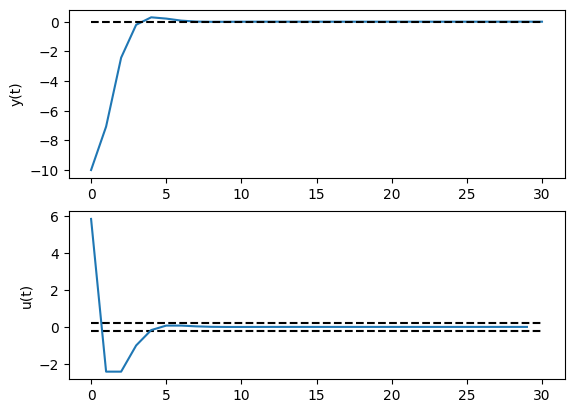

In [6]:
Uopt, Xopt = optno.solve(x0, verbose=True)

fig, axs = plt.subplots(2)
axs[0].plot(C@Xopt)
axs[0].plot([0, N], [0, 0], 'k--')
axs[0].set_ylabel("y(t)")

axs[1].plot([0,N], [umax, umax], 'k--')
axs[1].plot([0,N], [-umax, -umax], 'k--')
axs[1].plot(Uopt.T)
axs[1].set_ylabel("u(t)")

As discussed above and in the lecture, the MPC approach is to solve the finite horizon problem as above, but then we only apply the input `Uopt[:,0]` to the system. In the next time step, we measure (or estimate) the new state and then solve the finite horizon control problem again for this new state. 

In the rest of the notebook, we will study the MPC setting and LQR.

# 3. Linear quadratic control without constraints <a id="sec3">

In this part of the notebook, we consider the system:

$$\begin{aligned} x(t+1) &= \begin{bmatrix} 1 & 0.5 \\ 0 & 2 \end{bmatrix} x(t) + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u(t) \\ y(t) &= \begin{bmatrix} 0.5 & 0.5 \end{bmatrix} x(t) \end{aligned}$$

In [7]:
A = np.array([[1, 0.5], [0, 2]])
B = np.array([ [0], [1]])
C = np.array([0.5, 0.5])

This system is unstable. We can see this by looking at the poles, which are given by the eigenvalues of $A$.
However, the system is stabilizable (see definitions in Lecture 1). 

In [ ]:
#Stability of system
poles = np.linalg.eig(A)[0]
print("Poles:", poles)
print("Maximum rank:", A.shape[0])

#Reachability of system
S = np.hstack([B, A@B]) #Reachability matrix for a 2-dimensional system
print("Rank of S:", np.linalg.matrix_rank(S))

# We can also check the Hautus lemma
# Stabilizability of the system
print("Pole 1, rank:", np.linalg.matrix_rank(np.hstack([ poles[0]*np.eye(2) -A, B])))
print("Pole 2, rank:", np.linalg.matrix_rank(np.hstack([ poles[1]*np.eye(2) -A, B])))

Poles: [1. 2.]
Maximum rank: 2
Rank of S: 2
Pole 1, rank: 2
Pole 2, rank: 2


Due to the unstable dynamics of the system, the output will diverge towards $\pm \infty$ if we apply a constant input.

**Task:** The code block below simulates the LTI system.
* First try the constant input $u(t) = 1$.
* Then try $u(t) = 0$. If $x(0) = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$ we will stay at the origin, since this is an equilibrium.
* However, with a small perturbation of $x_2(0)$ (the state corresponding to the pole outside the unit circle) the output will blow up. Try e.g. $x(0) = \begin{bmatrix} 0 \\ 10^{-5} \end{bmatrix}$. 

[[0.000000e+00 5.000000e-06 1.500000e-05 3.500000e-05 7.500000e-05
  1.550000e-04 3.150000e-04 6.350000e-04 1.275000e-03 2.555000e-03
  5.115000e-03 1.023500e-02 2.047500e-02 4.095500e-02 8.191500e-02
  1.638350e-01 3.276750e-01 6.553550e-01 1.310715e+00 2.621435e+00
  5.242875e+00]
 [1.000000e-05 2.000000e-05 4.000000e-05 8.000000e-05 1.600000e-04
  3.200000e-04 6.400000e-04 1.280000e-03 2.560000e-03 5.120000e-03
  1.024000e-02 2.048000e-02 4.096000e-02 8.192000e-02 1.638400e-01
  3.276800e-01 6.553600e-01 1.310720e+00 2.621440e+00 5.242880e+00
  1.048576e+01]]


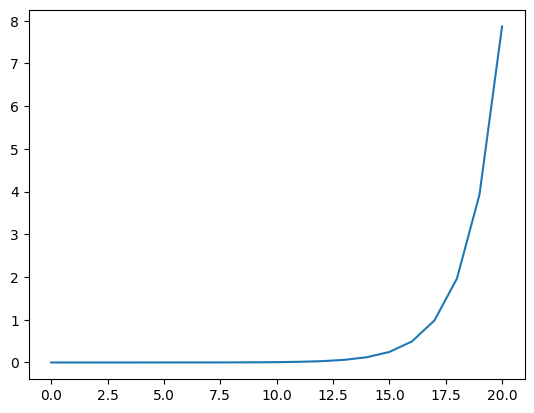

In [10]:
# Simulate the system with u(t) = 0
x0 = np.array([0, 10**(-5)]).reshape(2,1)
sys = LTI(A,B,x0)
#x = self.A@self.X[:,[-1]] + B@u 

for t in range(20):
    sys.step(np.ones(1)*0)

print(sys.X)
plt.plot(C@sys.X);

We can stabilize the system by applying a state feedback $u(t) = -L x(t)$. One way to design $L$ is to find the $L$ that minimize 
$$\sum_{t=0}^{\infty} x^\top(t) Q x(t) + u^\top(t) R u(t)$$

In the lecture, we saw that we find the optimal $L$ for the infinite horizon problem by solving the discrete-time algebraic Riccati equation (DARE)
$$ P_\infty = A^\top P_\infty A + Q - A^\top P_\infty B ( B^\top P B + R)^{-1} B^\top P_\infty A,$$
and then let $L = (B^\top P_\infty B + R)^{-1} B^\top P_\infty A$.

The closed-loop system is then 
$$ x(t+1) = (A-BL) x(t) $$
which is stable with the eigenvalues of $A-BL$ lying inside the unit circle. In the cell below we use `solve_discrete_are`, but later in the notebook you can see how to find $P_{\infty}$ via an iterative computation.

**Task**: Try to change $R$. If you increase $R$, you penalize the inputs more. We can note that increasing $R$ leads to smaller $L$. Try at least $R=0.1, 1, 10, 100$.

In [11]:
Q = np.eye(2)
R = 0.1*np.ones((1,1))
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A
print("Feedback gain L:", L)
print("Closed-loop poles:", np.linalg.eig(A-B@L)[0])

Feedback gain L: [[0.65822015 2.24245932]]
Closed-loop poles: [0.61713187 0.14040881]


We now try to simulate the system using our feedback $u(t) = -L x(t)$

**Task:** Try e.g. $R=0.1, 1, 10, 100$.

[0.5 0.5]
[[-5.00000000e+00 -7.50000000e+00 -5.24830133e+00 -3.32592111e+00
  -2.06475127e+00 -1.27593951e+00 -7.87663835e-01 -4.86126277e-01
  -3.00008766e-01 -1.85145636e-01 -1.14259366e-01 -7.05131088e-02
  -4.35158883e-02 -2.68550416e-02 -1.65731020e-02 -1.02277894e-02
  -6.31189473e-03 -3.89527138e-03 -2.40389610e-03 -1.48352088e-03
  -9.15528012e-04 -5.65001510e-04 -3.48680437e-04 -2.15181809e-04
  -1.32795551e-04 -8.19523663e-05 -5.05754168e-05 -3.12117013e-05
  -1.92617355e-05 -1.18870308e-05 -7.33586549e-06 -4.52719636e-06
  -2.79387714e-06 -1.72419061e-06 -1.06405297e-06 -6.56660996e-07
  -4.05246426e-07 -2.50090483e-07 -1.54338807e-07 -9.52473958e-08
  -5.87802031e-08 -3.62751364e-08 -2.23865427e-08 -1.38154488e-08
  -8.52595373e-09 -5.26163774e-09 -3.24712432e-09 -2.00390389e-09
  -1.23667295e-09 -7.63190284e-10 -4.70989044e-10]
 [-5.00000000e+00  4.50339734e+00  3.84476044e+00  2.52233967e+00
   1.57762352e+00  9.76551360e-01  6.03075116e-01  3.72235022e-01
   2.29726259e-

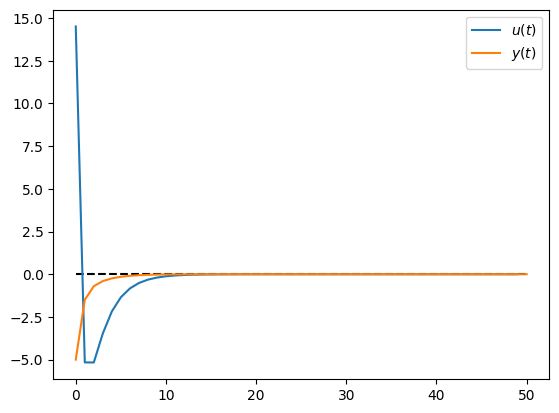

In [12]:
#Its all from the cost function J, Verify the relationship between J:Q,R and L.
#Here we dont just randomly pick u, we let u be indirectly affected from the const function J 
#with using L to update u, u=-Lk. It is therefore necessary to understand the cost function and what it says!
Q = np.eye(2)
R = 0.1*np.ones((1,1))
x0 = np.array([-5, -5]).reshape(2,1)

Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

sys = LTI(A,B,x0)
x = x0
for t in range(50):
    u = -L@x
    x = sys.step(u)

plt.plot([0, 50], [0, 0], 'k--')
plt.plot(sys.U.T, label="$u(t)$")
print(C)
print(sys.X)
plt.plot(C@sys.X, label="$y(t)$")
plt.legend()

## 3.1 Unconstrained linear quadratic MPC <a id="sec3_1">

Now, we will consider the linear quadratic MPC without any constraints.

That is, at each time-step $t$, we solve the finite-horizon optimization problem 
$$\begin{aligned} \min_{u_0, \ldots, u_{N-1}} &\, x_N^\top P x_N + \sum_{k=0}^{N-1} \left( x_k^\top Q x_k + u_k^\top R u_k \right) \\
\text{s.t.} &\, x_{k+1} = A x_k + B u_k, \, x_0 = x(t) \end{aligned}$$
and then apply the input 
$$u(t) = u_0^*$$

The cell block below runs MPC and LQR on our system and plots their corresponding outputs. 

**Task**: 
* Try to change the horizon. Use for example $N=1,2,3,5,10,100$.
* We can also add a terminal cost by setting $P\neq0$. Try for example $P = \rho I$, with $\rho = 0, 1, 5, 10, 100$, using $N=2$.
* An interesting choice is to choose $P = P_{\infty}$ (the solution to the Riccati equation). In this case the finite-horizon problem is equivalent to the infinite horizon problem, and you should get the same solutions even for $N=1$. 

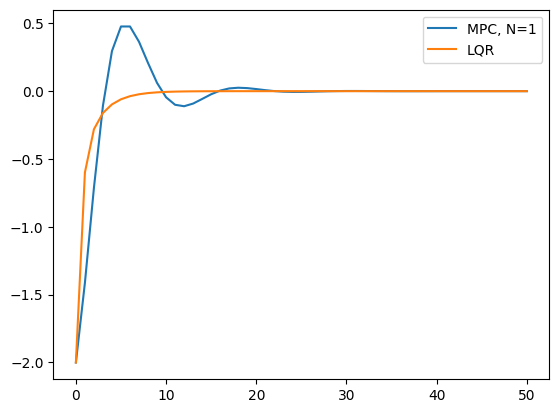

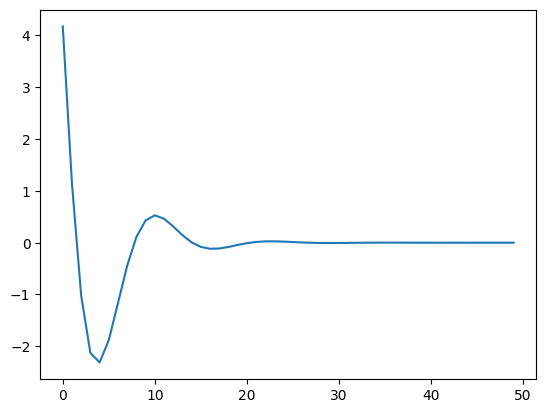

In [13]:
# LQR solution
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

# Setup the finite horizon optimization problem 
N = 1
Q = np.eye(2)
R = np.ones((1,1)) 
#P = 200000*np.eye(2) # No terminal cost
#P = 5*np.eye(2)
P = Pinf
opt = FiniteHorizon(A,B,C,P,Q,R,N)

# Initialize the system
x0 = np.array([-2, -2]).reshape(2,1)

sysMPC = LTI(A,B,x0)
sysLQR = LTI(A,B,x0)
xMPC = x0
xLQR = x0
u2 = []

# Run the simulation
for t in range(50):
    ## MPC
    Uopt,Xopt = opt.solve(xMPC)
    u = Uopt[:,0]
    u2.append(u)
    xMPC = sysMPC.step(u)

    ## LQR
    u = -L@xLQR
    xLQR = sysLQR.step(u)

plt.figure()
plt.plot(C@sysMPC.X, label="MPC, N=%d" % (N))
plt.plot(C@sysLQR.X, label="LQR")
plt.legend()

plt.figure()
plt.plot(u2)

### Explicit solution for unconstrained linear quadratic MPC

In the unconstrained case, we have seen that the finite horizon problem has the solution $P_N = P$ and for $0 \leq j \leq N-1$, we have
$$\begin{aligned} P_j &= A^\top P_{j+1} A + Q - A^\top P_{j+1} B(B^\top P_{j+1} B + R)^{-1} B^\top P_{j+1} A \\ 
L_j &= (B^\top P_{j+1} B + R)^{-1} B^\top P_{j+1} A \\
u_j^* &= - L_j x_j\end{aligned}$$
And in the MPC framework, we thus use $u(t) = -L_0 x(t)$. 

The cell below computes $L_0$ using the above equations and compares the poles of the closed-loop system $A-BL_0$ with those given by the infinite-horizon $A-BL$.

**Task:**
* Try different horizons in the MPC. Try at least $N=1,2,3,5,10,100$. How does this relate to your simulations above?
* Try to add terminal cost by initializing $P = I$. What happens with the poles for $N=2$ in this case? Does this align wih your simulation above?
* Try terminal cost $P=10I$ when $N=2$. What happened with the closed-loop poles? Does this align with your observations from the simulation above?

*Note:* The code can be used to solve the discrete-time algebraic Riccati equation by choosing $N$ large enough!

In [14]:
Q = np.eye(2)
R = np.ones((1,1)) 

PN = np.zeros((2,2))
#PN = 10*np.eye(2)ls
N = 50

# Compute P_{N-1}, ..., P_{1}
P = PN
for j in range(N-1):
    P = A.T@P@A + Q - A.T@P@B@np.linalg.inv(B.T@P@B + R)@B.T@P@A
    
L0 = np.linalg.inv(B.T@P@B + R)@B.T@P@A

# Infinite horizon feedback
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

print("MPC: L0=", L0,". Closed-loop poles: ", np.linalg.eig(A-B@L0)[0])
print("LQR:  L=", L,". Closed-loop poles: ", np.linalg.eig(A-B@L)[0])

MPC: L0= [[0.37393251 1.90731521]] . Closed-loop poles:  [0.68359751 0.40908728]
LQR:  L= [[0.37393251 1.90731521]] . Closed-loop poles:  [0.68359751 0.40908728]


**If you do not believe the derivations (and/or my implementation)**, we finally simulate the unconstrained MPC problem using the feedback $u =-L_0 x(t)$ computed above and `FiniteHorizon` to solve the optimization in each time step. Then, we should get exactly the same outputs (up to numerical errors in the optimization). 

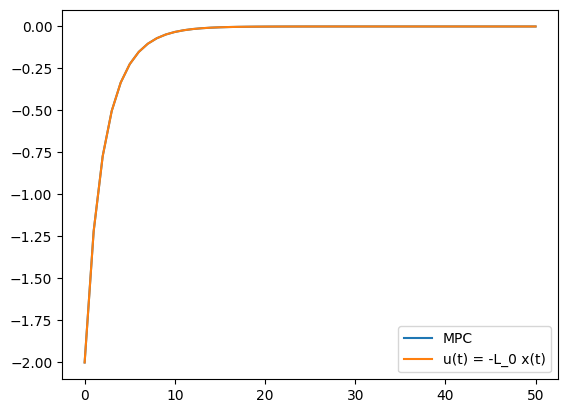

In [15]:
opt = FiniteHorizon(A,B,C,PN,Q,R,N)

# Initialize the system
x0 = np.array([-2, -2]).reshape(2,1)
sysMPC = LTI(A,B,x0)
sysSF = LTI(A,B,x0) 
xMPC = x0
xSF = x0

# Run the simulation
for t in range(50):
    ## MPC
    Uopt,Xopt = opt.solve(xMPC) 
    u = Uopt[:,[0]]
    xMPC = sysMPC.step(u)

    ## Using state feedback
    u = -L0@xSF
    xSF = sysSF.step(u)

plt.figure()
plt.plot(C@sysMPC.X, label="MPC")
plt.plot(C@sysSF.X, label="u(t) = -L_0 x(t)")
plt.legend();

# 4. Linear quadratic control with input constraints <a id="sec4">

In this part of the notebook, we will use the same system as in the lecture slides. That is
$$
\begin{aligned}
x(t+1) &= \begin{bmatrix} 2 & -1 \\ 1 & 0 \end{bmatrix} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} u(t) \\
y(t)&= \begin{bmatrix} 0.5 & 0.5 \end{bmatrix} x(t)
\end{aligned}
$$
We will also add the constraint
$$
|u(t)| \leq 0.2
$$

In [16]:
A = np.array([[2, -1], [1, 0]])
B = np.array([ [1], [0]])
C = np.array([0.5, 0.5])
umax=0.2

The code below computes the infinite horizon LQR (assuming no constraints) and the MPC solution, which takes constraints into account.
In the plot, the dashed line shows the inputs the respective controllers wanted to apply, and the solid line shows the input actually applied. (In the MPC, these will lie on top of each other since we took the constraints into account in the optimization problem.)  

**Task:**
* Try different values of $R$. E.g. $R=1,500$ (as we did in the lecture).
* Try different horizons $N$. E.g. $N=2,5,10,20$. Try both with $R=1$ and $R=500$.
* You can also try to solve the MPC problem without taking the constraints into account. (Remove `umax=umax` when you create `opt`). Note that, if the horizon is long enough, we will again behave as the LQR in this case.

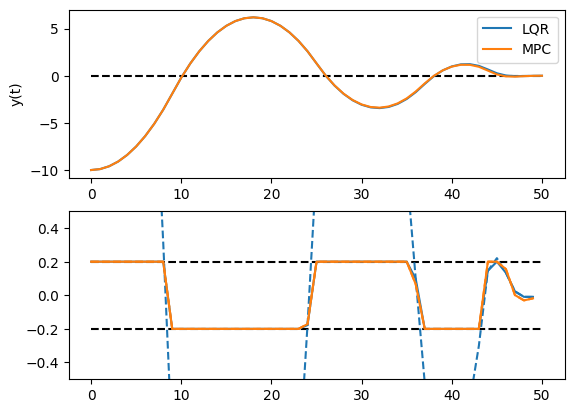

In [17]:
# Setting up the optimization problem
Q = np.eye(2)
R = np.ones((1,1)) 
P = Q
N = 2

# Compute feedback gain by solving the constraint-free infinite horizon problem
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

# Setting up the MPC optimizer
opt = FiniteHorizon(A,B,C,P,Q,R,N,umax=umax)

# Initialize the system
x0 = np.array([-10, -10]).reshape(2,1)
sysLQR = LTI(A,B,x0, umax=umax)
sysMPC = LTI(A,B,x0, umax=umax)
xLQR = x0
xMPC = x0

# Save inputs before they are constrained
uLQR = np.zeros((1,50))
uMPC= np.zeros((1,50))

# Run the simulation
for t in range(50):
    #MPC
    Uopt,Xopt = opt.solve(xMPC) 
    u = Uopt[:,[0]]
    uMPC[:,t] = u
    xMPC = sysMPC.step(u)
    
    #LQR
    u = -L@xLQR
    uLQR[:,t] = u
    xLQR = sysLQR.step(u)

fig, axs = plt.subplots(2)

axs[0].plot([0, 50], [0, 0], 'k--')
axs[0].plot(C@sysLQR.X, color='#1f77b4', label="LQR")
axs[0].plot(C@sysMPC.X, color='#ff7f0e', label="MPC")
axs[0].legend()
axs[0].set_ylabel("y(t)")

axs[1].set_ylim([-0.5,0.5])
axs[1].plot([0, 50], [0.2, 0.2], 'k--')
axs[1].plot([0, 50], [-0.2, -0.2], 'k--')
axs[1].plot(sysLQR.U.T, color='#1f77b4')
axs[1].plot(uLQR.T, '--', color='#1f77b4')
axs[1].plot(sysMPC.U.T, color='#ff7f0e');
axs[1].plot(uMPC.T, '--', color='#ff7f0e');

# 5. State constraints, terminal region and feasability. <a id="sec5">

In this part of the notebook, we will try a third-order system.

$$\begin{aligned} x(t+1) &= \begin{bmatrix} 1 & 1 & 0 \\ 0 & 2 & 1 \\ 0 & 0 & 3 \end{bmatrix} x(t) + \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix} u(t) \\ y(t) &= \begin{bmatrix} 1 & 0 & 0 \end{bmatrix} x(t) \end{aligned}$$

We can note that the poles of the system are 1, 2 and 3, so the system is unstable. However, the system is stabilizable. We consider no constraints in the system.

In [18]:
A = np.array([[1,1,0], [0, 2, 1], [0, 0, 3]])
B = np.array([ [0], [0], [1]])
C = np.array([1, 0 ,0])

We first use the dynamic programming approach to see how long horizon we need in order to stabilize the system.

**Task:**
* Start with $N=2$ and then increase $N$ until the closed-loop system is stable for the MPC.
* Also try to increase $R$ from 1 to 10. Does this change how long horizon you need to stabilize the system?

In [19]:
Q = np.eye(3)
R = np.ones((1,1)) 
PN = np.zeros((3,3))
N = 3

# Compute P_{N-1}, ..., P_{1}
P = PN
for j in range(N-1):
    P = A.T@P@A + Q - A.T@P@B@np.linalg.inv(B.T@P@B + R)@B.T@P@A
    
L0 = np.linalg.inv(B.T@P@B + R)@B.T@P@A

# Infinite horizon feedback
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

print("MPC: L0=", L0,". Closed-loop poles: ", np.linalg.eig(A-B@L0)[0])
print("LQR:  L=", L,". Closed-loop poles: ", np.linalg.eig(A-B@L)[0])

MPC: L0= [[0.         0.53333333 2.86666667]] . Closed-loop poles:  [1.         1.64785319 0.48548014]
LQR:  L= [[0.13048583 3.32624875 4.5468018 ]] . Closed-loop poles:  [0.57542429+0.08228977j 0.57542429-0.08228977j 0.30234962+0.j        ]


Next we try to run the system both with LQR and with MPC.

**Task:**
* Try at least $N=3, 5, 10, 20$.

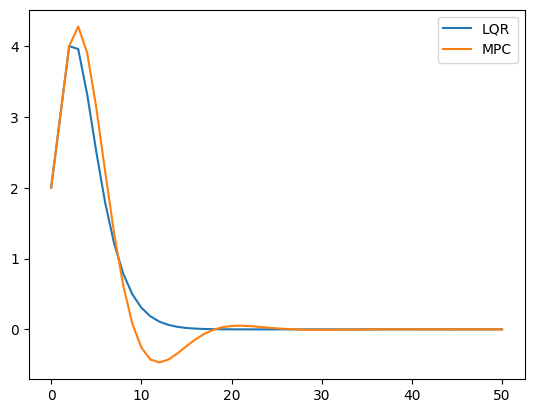

In [20]:
Q = np.eye(3)
R = np.ones((1,1)) 
P = np.zeros((3,3)) 
N = 5 
opt = FiniteHorizon(A,B,C,P,Q,R,N)

# LQR solution
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

# Initialize the system
x0 = np.array([2, 1, -1]).reshape(3,1)
sysMPC = LTI(A,B,x0)
sysLQR = LTI(A,B,x0) 
xMPC = x0
xLQR = x0

# Run the simulation
for t in range(50):
    ## MPC
    Uopt,Xopt = opt.solve(xMPC) 
    u = Uopt[:,[0]]
    xMPC = sysMPC.step(u)
    
    #LQR
    u = -L@xLQR
    xLQR = sysLQR.step(u)

plt.figure()
plt.plot(C@sysLQR.X, label="LQR")
plt.plot(C@sysMPC.X, label="MPC")
plt.legend();

## 5.1 Adding state and input constraints <a id="sec5_1">

We now add the constraints 
$$
|y_k| = |C x_k| \leq 4, \quad |u_k| \leq 5.
$$
In this case, the problem may not be feasible for all states $x(t)$. 

Let us try some different horizons, to see when the initial state $x(0) = \begin{bmatrix} 2 & 1 & -1 \end{bmatrix}^\top$ gives a feasible problem.

**Task:**
* Try to see if the initial state is feasible for $N=2,3,5,10$.
* Another interesting thing to try: Set `umax=4` and try $N=2,5,10$. Can you explain these results?

Optimizer status: optimal
X[N] =  [ 4.   0.5 -4.5]


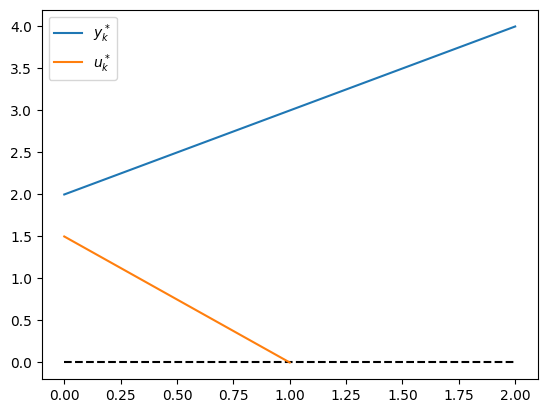

In [21]:
Q = np.eye(3)
R = np.ones((1,1)) 
P = np.zeros((3,3))
N = 2
opt = FiniteHorizon(A,B,C,P,Q,R,N, umax=5, ymax=4)

x0 = np.array([2, 1, -1]).reshape(3,1)
Uopt, Xopt = opt.solve(x0)
print("Optimizer status:", opt.prob.status)
if opt.prob.status == 'optimal':
    print("X[N] = ", Xopt[:,-1])
    plt.figure()
    plt.plot([0, N], [0, 0], 'k--')
    plt.plot(C@Xopt, label='$y_k^*$')
    plt.plot(Uopt.T, label='$u_k^*$')
    plt.legend();

Let us now run MPC in this setting. If the problem becomes infeasible at any time step, the simulation will stop.

**Task:**
* Use initial state $x(0) = \begin{bmatrix} 2 & 1 & -1 \end{bmatrix}^\top$. Increase the prediction horizon, starting from $N=2$, until it is stable for the full trajectory. Also try $N=10$.
* Do the same for the initial state $\begin{bmatrix} -0.5 & 0.13 & -0.15 \end{bmatrix}^\top$.

Final state: [ 3.   1.  -1.5]


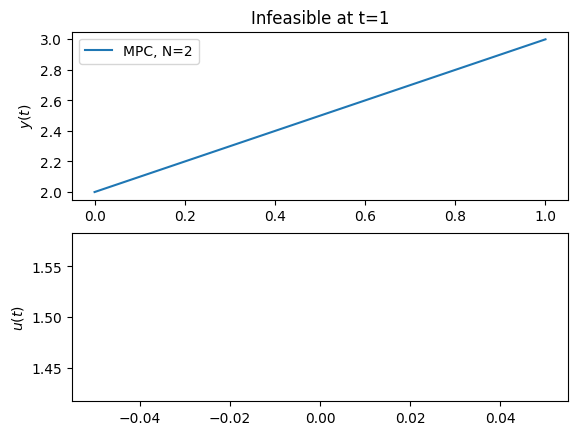

In [22]:
Q = np.eye(3)
R = np.ones((1,1)) 
P = np.zeros((3,3))
N = 2
opt = FiniteHorizon(A,B,C,P,Q,R,N, umax=5, ymax=4)

# LQR solution
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

# Initialize the system
x0 = np.array([2, 1, -1]).reshape(3,1)
#x0 = np.array([-0.5, 0.13, -0.15]).reshape(3,1)
sysMPC = LTI(A,B,x0, umax=10)
xMPC = x0

# Run the simulation
for t in range(100):
    ## MPC
    Uopt,Xopt = opt.solve(xMPC) 
    if Uopt is None:
        break
        
    u = Uopt[:,[0]]
    xMPC = sysMPC.step(u)

fig, axs = plt.subplots(2)
print("Final state:", sysMPC.X[:,-1])
if Uopt is None:
    axs[0].set_title("Infeasible at t=%d" % (t))
else:
    axs[0].set_title("Feasible for all t")
    
axs[0].plot(C@sysMPC.X, label="MPC, N=%d" % (N))
axs[0].set_ylabel("$y(t)$")
axs[0].legend()

axs[1].plot(sysMPC.U.T)
axs[1].set_ylabel("$u(t)$");

## 5.2 Adding terminal constraint <a id="sec5_2">

We will now add the constraint $x_N = 0$ to the optimization problem. Note that this is equivalent to setting $\mathcal{X}_f = \{0\}$.

You can read the note "Terminal constraint for recursive feasibility" on Studium to see that this implies that, if the optimization problem is feasible at $t=0$, then it will be feasible for all $t$. Furthermore, if $x(0)$ is feasible, then $x(t) \rightarrow 0$ and $u(t) \rightarrow 0$.

**However, if the horizon is too short**, or even if the horizon is long but we start in a state we cannot recover from, we may not be able to reach the origin within the prediction horizon. That is, it is impossible to find inputs in $\mathcal{U}$ that take us from $x(0)$ to $x(N) = 0$. 

**Task:**
* Increase the horizon from $N=2$ until the intial state becomes feasible, with initial state $x_0 = \begin{bmatrix} 2 & -1 & 1 \end{bmatrix}^\top$.
* Do the same with initial state $x_0 = \begin{bmatrix} -0.5 & 0.13 & -0.15 \end{bmatrix}^\top$. Compare with your results above. Also compare the result for this initial state when $N=4$ with the results above.

Final state: [ 2  1 -1]


/home/sajren/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


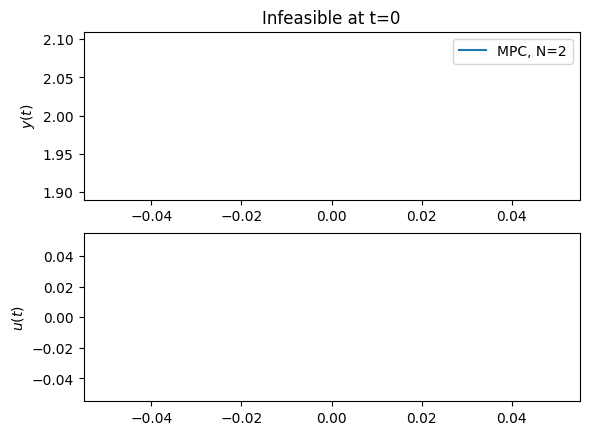

In [23]:
Q = np.eye(3)
R = np.ones((1,1)) 
P = np.zeros((3,3))
N = 2
opt = FiniteHorizon(A,B,C,P,Q,R,N, umax=5, ymax=4, terminal=True)

# LQR solution
Pinf = sp.linalg.solve_discrete_are(A, B, Q, R)
L = np.linalg.inv(B.T@Pinf@B + R)@B.T@Pinf@A

# Initialize the system
x0 = np.array([2, 1, -1]).reshape(3,1)
#x0 = np.array([-0.5, 0.13, -0.15]).reshape(3,1)
sysMPC = LTI(A,B,x0, umax=10)
xMPC = x0

# Run the simulation
for t in range(40):
    ## MPC
    Uopt,Xopt = opt.solve(xMPC) 
    if Uopt is None:
        break
        
    u = Uopt[:,[0]]
    xMPC = sysMPC.step(u)

fig, axs = plt.subplots(2)
print("Final state:", sysMPC.X[:,-1])
if Uopt is None:
    axs[0].set_title("Infeasible at t=%d" % (t))
else:
    axs[0].set_title("Feasible for all t")
    
axs[0].plot(C@sysMPC.X, label="MPC, N=%d" % (N))
axs[0].set_ylabel("$y(t)$")
axs[0].legend()

axs[1].plot(sysMPC.U.T)
axs[1].set_ylabel("$u(t)$");